# TPE Hyperparameter Optimization of CNN - Hyperopt

In this notebook, we will use **TPE driven Bayesian Optimization** to select the best **hyperparameters** for a CNN that recognizes digits in images, using the MNIST dataset 

## Download dataset

- Navigate to the [MNIST website in Kaggle](https://www.kaggle.com/c/digit-recognizer/data)
- Download the train.csv file
- Unzip and copy the train.csv file to where you see the SAVE_DATASETS-HERE.txt file
- Rename to mnist.csv

**Remember that you need to be logged in to be able to download the dataset**

## Notebook content

- Data Preparation
- Set up the hyperparameter search shape
- Set up a simple CNN
- Set up the objective function
- Perform Bayesian Optimization
- Evaluate Model Performance

In [12]:
import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(1234)
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Sequential, load_model
from keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from hyperopt import hp, tpe, fmin, Trials


#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()


In [14]:
X_train.shape

(60000, 28, 28)

In [15]:
# Ajustar a dimensão do MNIST
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalizar os valores dos pixels para o intervalo [0, 1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Verificar as novas formas
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


### Target encoding

In [16]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

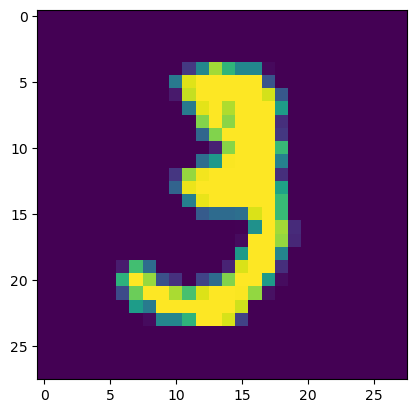

In [17]:
g = plt.imshow(X_train[10][:, :, 0])

## Define the hyperparameter space

We want to find the following hyper-parameters:

- The learning rate of the optimizer.
- The number of convolutional layers.
- The number of fully-connected Dense layers.
- The number of nodes (neurons) for each of the dense layers.
- Whether to use 'sigmoid' or 'relu' activation in all the layers.

In [18]:
param_grid = {
    'learning_rate': hp.uniform('learning_rate', 1e-6, 1e-2),
    'num_conv_layers': hp.quniform('num_conv_layers', 1, 3, 1),
    'num_dense_layers': hp.quniform('num_dense_layers', 1, 5, 1),
    'num_dense_nodes': hp.quniform('num_dense_nodes', 5, 512, 1),
    'activation': hp.choice('activation', ['relu', 'sigmoid']),
}

# Define the CNN

We will create a CNN, with 2 Convolutional layers followed by Pooling, and varying number of fully-connected Dense layers. Each Convlutional layer, can itself have more than 1 conv layer.

In [19]:
# function to create the CNN

def create_cnn(
    # the hyperparam to optimize are passed
    # as arguments
    learning_rate,
    num_conv_layers,
    num_dense_layers,
    num_dense_nodes,
    activation,
):
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # First convolutional layer.
    # There are many hyper-parameters in this layer
    # For this demo, we will optimize the activation function and
    # the number of convolutional layers that it can take.
    
    # We add the different number of conv layers in the following loop:
    
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Same hyperparameters to optimize as previous layer.
    for i in range(num_conv_layers):
        model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                         activation=activation))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:
    
    for i in range(num_dense_layers):
        
        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(learning_rate=learning_rate)

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### Define the objective function

In [20]:
path_best_model = 'cnn_model.keras'
best_accuracy = 0

In [23]:
def objective(params):
    
    """
    Hyper-parameters:
    learning_rate:        Learning-rate for the optimizer.
    convolutional layers: Number of conv layers.
    num_dense_layers:     Number of dense layers.
    num_dense_nodes:      Number of nodes in each dense layer.
    activation:           Activation function for all layers.
    """

    # Print the hyper-parameters.        
    print('learning rate: ', params['learning_rate'])
    print('num_conv_layers: ', int(params['num_conv_layers']))
    print('num_dense_layers: ',int(params['num_dense_layers']))
    print('num_dense_nodes: ', int(params['num_dense_nodes']))
    print('activation: ', params['activation'])
    print()
    
    # Create the neural network with the hyper-parameters.
    # We call the function we created previously.
    model = create_cnn(learning_rate=params['learning_rate'],
                       num_conv_layers=int(params['num_conv_layers']),
                       num_dense_layers=int(params['num_dense_layers']),
                       num_dense_nodes=int(params['num_dense_nodes']),
                       activation=params['activation'],
                       )

   
    # Set a learning rate annealer
    # this reduces the learning rate if learning does not improve
    # for a certain number of epochs
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
   
    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(x=X_train,
                        y=y_train,
                        epochs=20,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=learning_rate_reduction)

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    
    # Remember that hyperopt always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return -accuracy

## Test run

In [24]:
default_parameters = {
    'learning_rate': 1e-5,
    'num_conv_layers': 1,
    'num_dense_layers': 1,
    'num_dense_nodes': 16,
    'activation': 'relu',
}


objective(default_parameters)

learning rate:  1e-05
num_conv_layers:  1
num_dense_layers:  1
num_dense_nodes:  16
activation:  relu

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1821 - loss: 2.2859 - val_accuracy: 0.3425 - val_loss: 2.1925 - learning_rate: 1.0000e-05
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3459 - loss: 2.1464 - val_accuracy: 0.5047 - val_loss: 1.9315 - learning_rate: 1.0000e-05
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5261 - loss: 1.8700 - val_accuracy: 0.6763 - val_loss: 1.5621 - learning_rate: 1.0000e-05
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6581 - loss: 1.5087 - val_accuracy: 0.7708 - val_loss: 1.1746 - learning_rate: 1.0000e-05
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7432 - loss: 1.1526 - val_accuracy: 0.8260 - val_loss: 0.8616 - learning_rate: 1.0000e-05
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7995 - loss: 0.8780 - val_accuracy: 0.8580 - val_lo

-0.9445000290870667

We obtained a mediocre accuracy, but all our code is working. So let's get started with the Optimization now!!

## Bayesian Optiomization with TPE

In [ ]:
trials = Trials()

search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=30,
    rstate=np.random.default_rng(42),
    algo=tpe.suggest,  # tpe
    trials=trials
)

learning rate:                                        
0.006517772255089191                                  
num_conv_layers:                                      
3                                                     
num_dense_layers:                                     
3                                                     
num_dense_nodes:                                      
418                                                   
activation:                                           
relu                                                  
Epoch 1/20                                            

  1/422 ━━━━━━━━━━━━━━━━━━━━ 12:39 2s/step - accuracy: 0.1094 - loss: 2.3015
  3/422 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.0946 - loss: 5.0317
  5/422 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.0968 - loss: 4.8246
  7/422 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.1028 - loss: 4.5381
  9/422 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.1072 - loss: 4.2986
 11/422 ━

## Analyse the results

In [ ]:
trials.argmin

In [ ]:
trials.best_trial

In [ ]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

In [ ]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

## Evaluate the model

In [ ]:
model = load_model(path_best_model)

In [ ]:
result = model.evaluate(X_test, y_test)

In [ ]:
#print evaluation metrics 